In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import webbrowser
import os
import numpy as np
  
df = pd.read_csv("Tema_4.csv")


# Paleta de colores personalizada
colores = {
    'principal': '#0047AB',   # azul eléctrico corporativo
    'oscuro': '#00264D',      # navy profundo
    'cian': '#00A6ED',        # acento brillante
    'dorado': '#C5A100',      # contraste elegante
    'gris': '#E5E5E5'         # fondo neutro
}

# Aplicar estilo general
plt.style.use('default')
sns.set_palette([colores['principal']])
sns.set_context("notebook", font_scale=1.0)
plt.rcParams.update({
    'axes.facecolor': 'white',
    'axes.edgecolor': colores['oscuro'],
    'grid.color': '#cccccc',
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

color_base = colores['principal']


# Análisis Exploratorio

El dataset contiene 4531 filas (registros) y 17 columnas


,Columnas,Tipo de dato,Valores no nulos,Valores nulos,Porcentaje nulos (%)
age,age,object,4305,226,4.99
job,job,object,4305,226,4.99
marital,marital,object,4305,226,4.99
education,education,object,4305,226,4.99
default,default,object,4305,226,4.99
balance,balance,float64,4306,225,4.97
housing,housing,object,4305,226,4.99
loan,loan,object,4304,227,5.01
contact,contact,object,4304,227,5.01
day,day,float64,4304,227,5.01


------------------------- VALORES NULOS DEL DATASET ------------------------


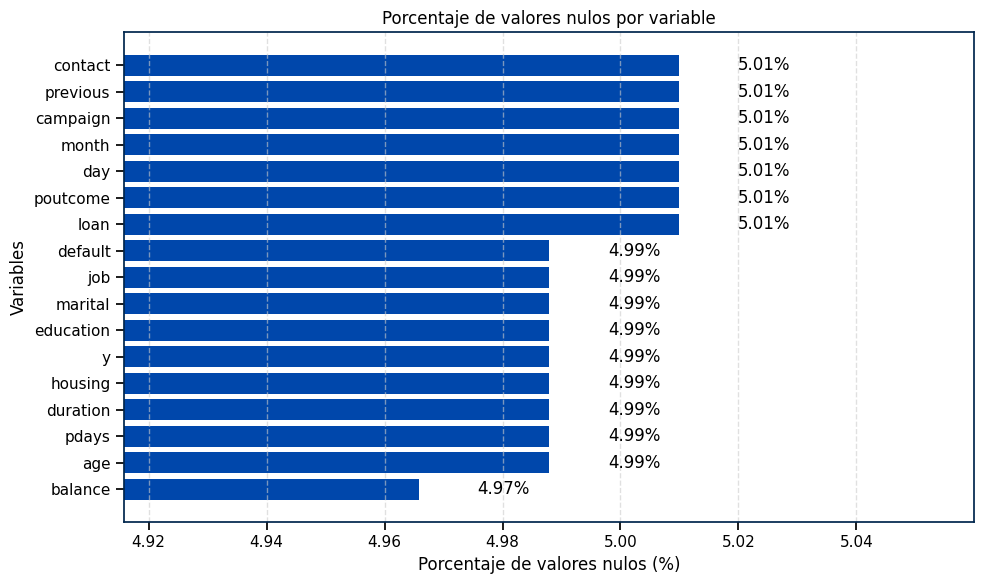

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:00<00:00, 184.55it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

-------------------- DISTRIBUCIÓN DE VARIABLES NUMÉRICAS CONTÍNUAS --------------------


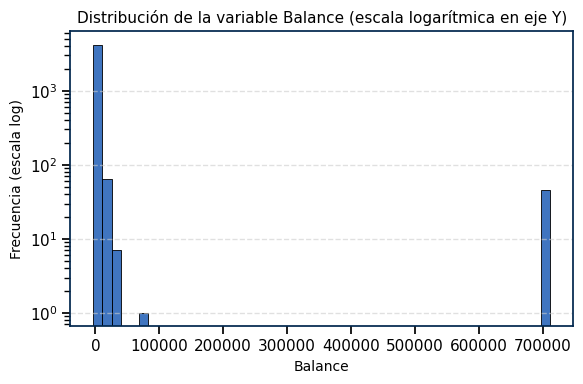

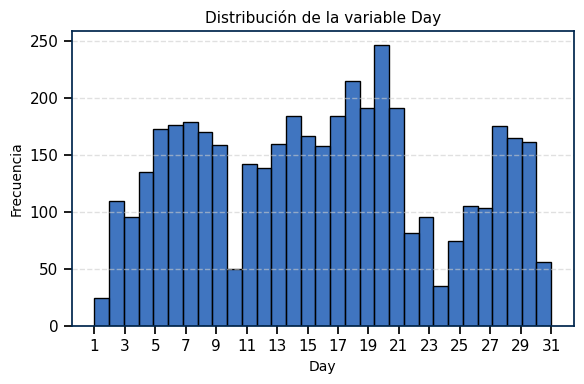

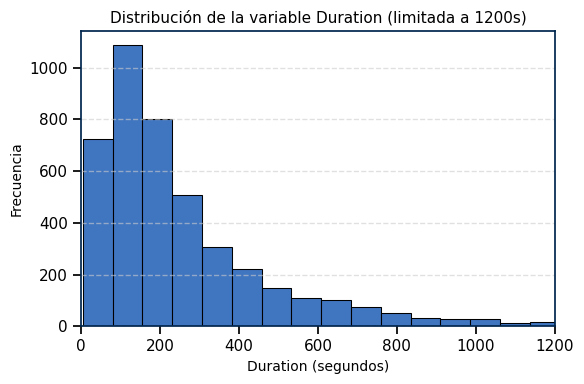

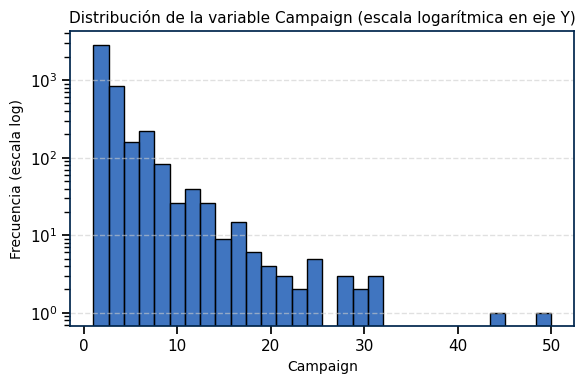

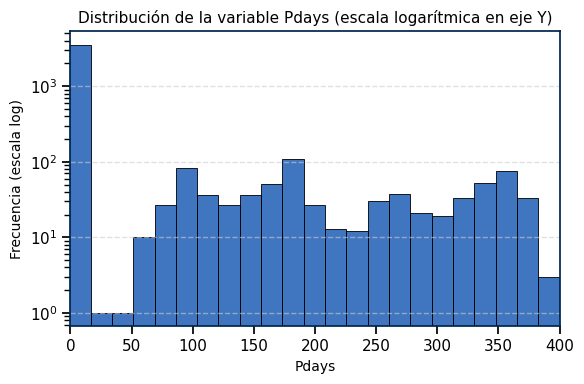

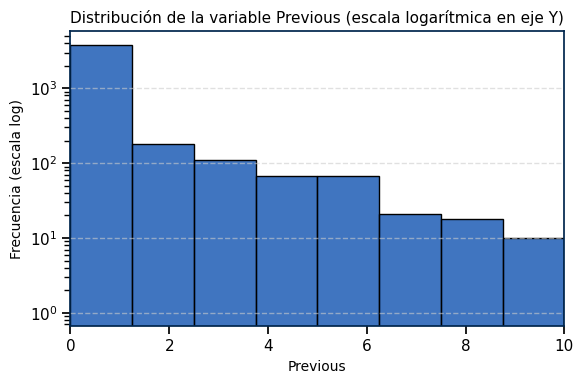

-------------------- DISTRIBUCIÓN DE VARIABLES BINARIAS --------------------


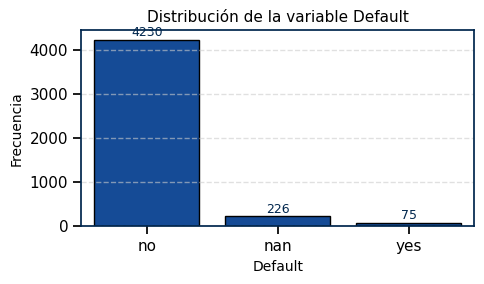

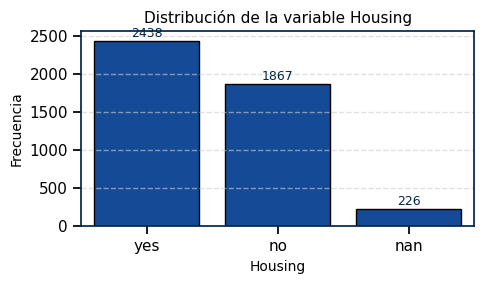

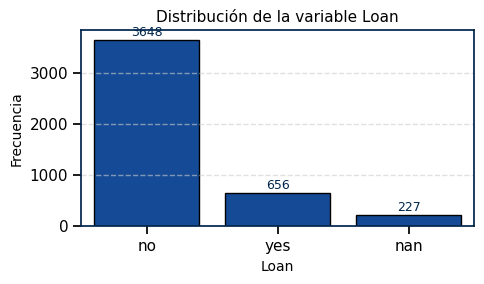

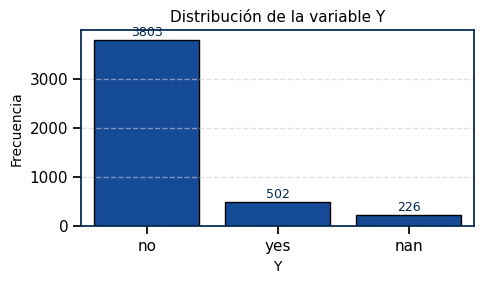

In [3]:
%matplotlib inline

print(f"El dataset contiene {df.shape[0]} filas (registros) y {df.shape[1]} columnas")

filas = df.shape[0]
columnas = df.shape[1]
total_celdas = df.size

info_df = pd.DataFrame({
    'Columnas': df.columns,
    'Tipo de dato': df.dtypes,
    'Valores no nulos': df.notnull().sum(),
    'Valores nulos': df.isnull().sum(),
    'Porcentaje nulos (%)': (df.isnull().sum() / len(df) * 100).round(2)
})

display(info_df)

print("------------------------- VALORES NULOS DEL DATASET ------------------------")
porcentaje_nulos = (df.isna().mean() * 100).sort_values()  # cálculo equivalente y claro

plt.figure(figsize=(10,6))
plt.barh(porcentaje_nulos.index, porcentaje_nulos.values)
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Variables')
plt.title('Porcentaje de valores nulos por variable')

# etiquetas con 2 decimales
for i, v in enumerate(porcentaje_nulos.values):
    plt.text(v + 0.01, i, f"{v:.2f}%", va='center')

# zoom del eje X para apreciar 4.9–5.1 %
minv, maxv = porcentaje_nulos.min(), porcentaje_nulos.max()
plt.xlim(minv - 0.05, maxv + 0.05)   # ajusta márgenes si querés más/menos zoom
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

profile = ProfileReport(df, title="Tema_4", explorative=True)
profile.to_file("Tema_4.html")

archivo_html = os.path.abspath("Tema_4.html")
webbrowser.open(f"file://{archivo_html}")


variables_numericas = ['balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
variables_binarias = ['default', 'housing', 'loan', 'y']
variables_categoricas = ['job', 'marital', 'education', 'contact', 'outcome']


print("-------------------- DISTRIBUCIÓN DE VARIABLES NUMÉRICAS CONTÍNUAS --------------------")

# --- BALANCE (escala logarítmica) ---
plt.figure(figsize=(6,4))
sns.histplot(df['balance'], bins=50, color=color_base, edgecolor='black', kde=False)
plt.yscale('log')
plt.title('Distribución de la variable Balance (escala logarítmica en eje Y)', fontsize=11)
plt.xlabel('Balance', fontsize=10)
plt.ylabel('Frecuencia (escala log)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# --- DAY ---
plt.figure(figsize=(6,4))
sns.histplot(df['day'], bins=31, color=color_base, edgecolor='black', kde=False)
plt.xticks(range(1,32,2))
plt.title('Distribución de la variable Day', fontsize=11)
plt.xlabel('Day', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- DURATION ---
plt.figure(figsize=(6,4))
sns.histplot(df['duration'], bins=40, color=color_base, edgecolor='black', kde=False)
plt.xlim(0, 1200)  # evita colas largas
plt.title('Distribución de la variable Duration (limitada a 1200s)', fontsize=11)
plt.xlabel('Duration (segundos)', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- CAMPAIGN (escala logarítmica en eje Y) ---
plt.figure(figsize=(6,4))
sns.histplot(df['campaign'], bins=30, color=color_base, edgecolor='black', kde=False)
plt.yscale('log')
plt.title('Distribución de la variable Campaign (escala logarítmica en eje Y)', fontsize=11)
plt.xlabel('Campaign', fontsize=10)
plt.ylabel('Frecuencia (escala log)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- PDAYS (escala logarítmica en eje Y) ---
plt.figure(figsize=(6,4))
sns.histplot(df['pdays'], bins=50, color=color_base, edgecolor='black', kde=False)
plt.xlim(0, 400)  # mantiene enfoque en valores útiles
plt.yscale('log')
plt.title('Distribución de la variable Pdays (escala logarítmica en eje Y)', fontsize=11)
plt.xlabel('Pdays', fontsize=10)
plt.ylabel('Frecuencia (escala log)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- PREVIOUS (escala logarítmica en eje Y) ---
plt.figure(figsize=(6,4))
sns.histplot(df['previous'], bins=20, color=color_base, edgecolor='black', kde=False)
plt.xlim(0, 10)
plt.yscale('log')
plt.title('Distribución de la variable Previous (escala logarítmica en eje Y)', fontsize=11)
plt.xlabel('Previous', fontsize=10)
plt.ylabel('Frecuencia (escala log)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("-------------------- DISTRIBUCIÓN DE VARIABLES BINARIAS --------------------")
for col in variables_binarias:
    plt.figure(figsize=(5,3))
    valores = df[col].value_counts(dropna=False)

    # Gráfico
    sns.barplot(
        x=valores.index.astype(str),
        y=valores.values,
        color=color_base,
        edgecolor='black'
    )
    
    # Ajustar margen superior dinámico
    plt.ylim(0, valores.max() * 1.15)  # 15% de espacio extra arriba

    # Etiquetas y título
    plt.title(f'Distribución de la variable {col.capitalize()}', fontsize=11)
    plt.xlabel(col.capitalize(), fontsize=10)
    plt.ylabel('Frecuencia', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Mostrar valores exactos sobre cada barra
    for i, v in enumerate(valores.values):
        plt.text(i, v + (valores.max() * 0.02), str(v), ha='center', fontsize=9, color=colores['oscuro'])
    
    plt.tight_layout()
    plt.show()

